In [39]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [161]:
from datetime import date
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [41]:
def get_names(dataframe):
    cols = dataframe.columns
    s = set()
    for col in cols:
        s.add(col[:col.find("_")])
    return list(s)

In [65]:
data = pd.read_csv("./data.csv")

In [66]:
data.reindex_axis(sorted(data.columns), axis=1)
data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

In [67]:
all_stocks = get_names(data)
use_stocks = ["GOOGL", "AAPL", "NFLX", "AMZN", "QCOM", "SBUX"]

In [68]:
def select_stocks(dataframe, stocks):
    transformed = list(map(lambda x : x + "_Cls%", stocks))
    selected = dataframe[transformed]
    selected.columns = stocks
    return selected

In [69]:
selected = select_stocks(data, use_stocks)
selected_all = select_stocks(data, all_stocks)

In [80]:
dataset = selected.tail(1100)

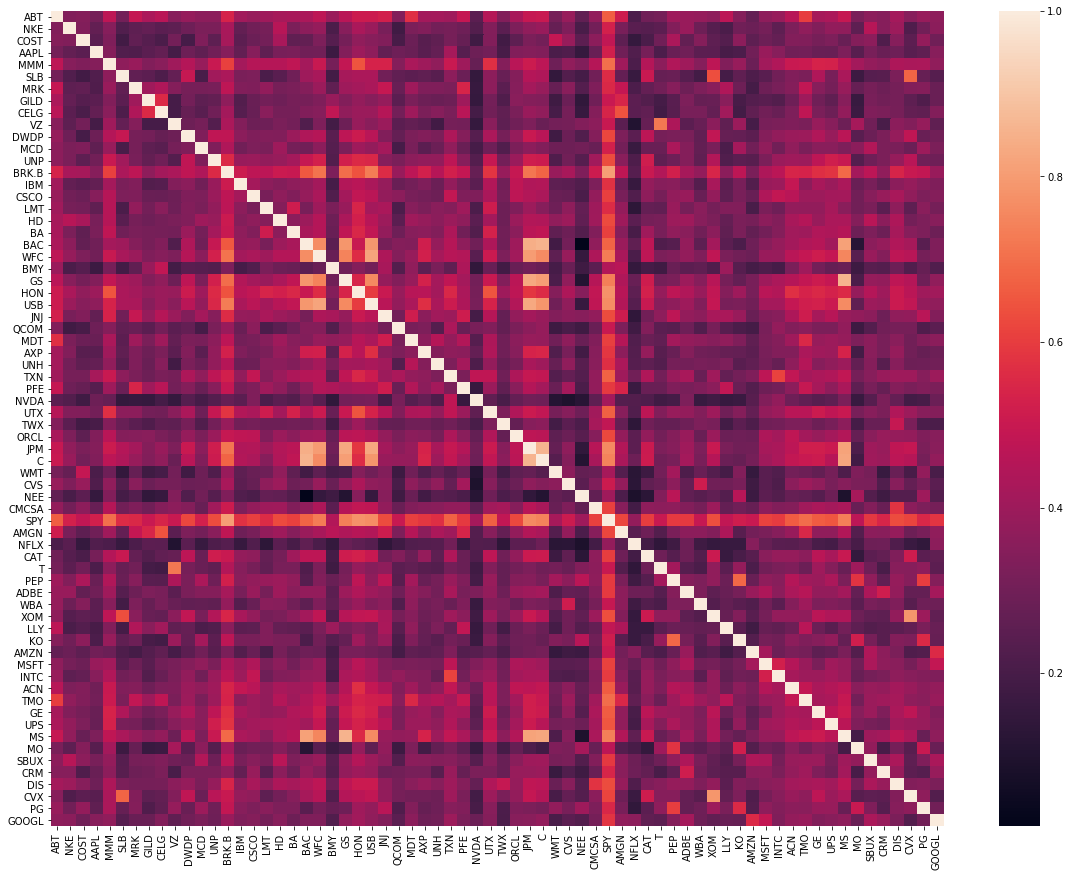

In [83]:
corr = selected_all.tail(1100).corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [84]:
dataset.corr()

,GOOGL,AAPL,NFLX,AMZN,QCOM,SBUX
GOOGL,1.000000,0.352547,0.362140,0.556565,0.247930,0.429022
AAPL,0.352547,1.000000,0.225136,0.302596,0.295702,0.315319
NFLX,0.362140,0.225136,1.000000,0.348343,0.182182,0.289736
AMZN,0.556565,0.302596,0.348343,1.000000,0.193580,0.438427
QCOM,0.247930,0.295702,0.182182,0.193580,1.000000,0.231536
SBUX,0.429022,0.315319,0.289736,0.438427,0.231536,1.000000


In [155]:
raw_dataset = dataset.tail(1000)
raw_outputs = raw_dataset.as_matrix()
feature_ma2 = dataset.rolling(window = 2, center=False).mean().tail(1000)
feature_ma3 = dataset.rolling(window = 3, center=False).mean().tail(1000)
feature_ma5 = dataset.rolling(window = 5, center=False).mean().tail(1000)
feature_ma7 = dataset.rolling(window = 5, center=False).mean().tail(1000)
feature_ma10 = dataset.rolling(window = 10, center=False).mean().tail(1000)
feature_ma30 = dataset.rolling(window = 30, center=False).mean().tail(1000)
features = np.hstack([feature_ma2, feature_ma3, feature_ma5,feature_ma7,feature_ma10,feature_ma30])

1 - linear regression model =)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(features, raw_outputs, test_size = 0.2, shuffle=False)

In [156]:
lin_model = linear_model.LinearRegression(fit_intercept=True)

In [163]:
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [167]:
y_train_prediction = lin_model.predict(X_train)

train dataset scores

In [168]:
print(r2_score(y_train, y_train_prediction, multioutput = "raw_values"))
print(mean_squared_error(y_train, y_train_prediction, multioutput = "raw_values"))

[ 0.56160666  0.52625564  0.54400286  0.50001462  0.51401623  0.54529063]
[ 0.93952099  1.08655987  3.67445271  1.95449742  1.34510905  0.71939746]


In [169]:
y_test_prediction = lin_model.predict(X_test)

In [170]:
print(r2_score(y_test, y_test_prediction, multioutput = "raw_values"))
print(mean_squared_error(y_test, y_test_prediction, multioutput = "raw_values"))

[ 0.50168324  0.45504167  0.44611179  0.49464481  0.47444974  0.47865662]
[ 0.49337799  0.5840032   1.86046107  0.969982    1.10116939  0.64392006]


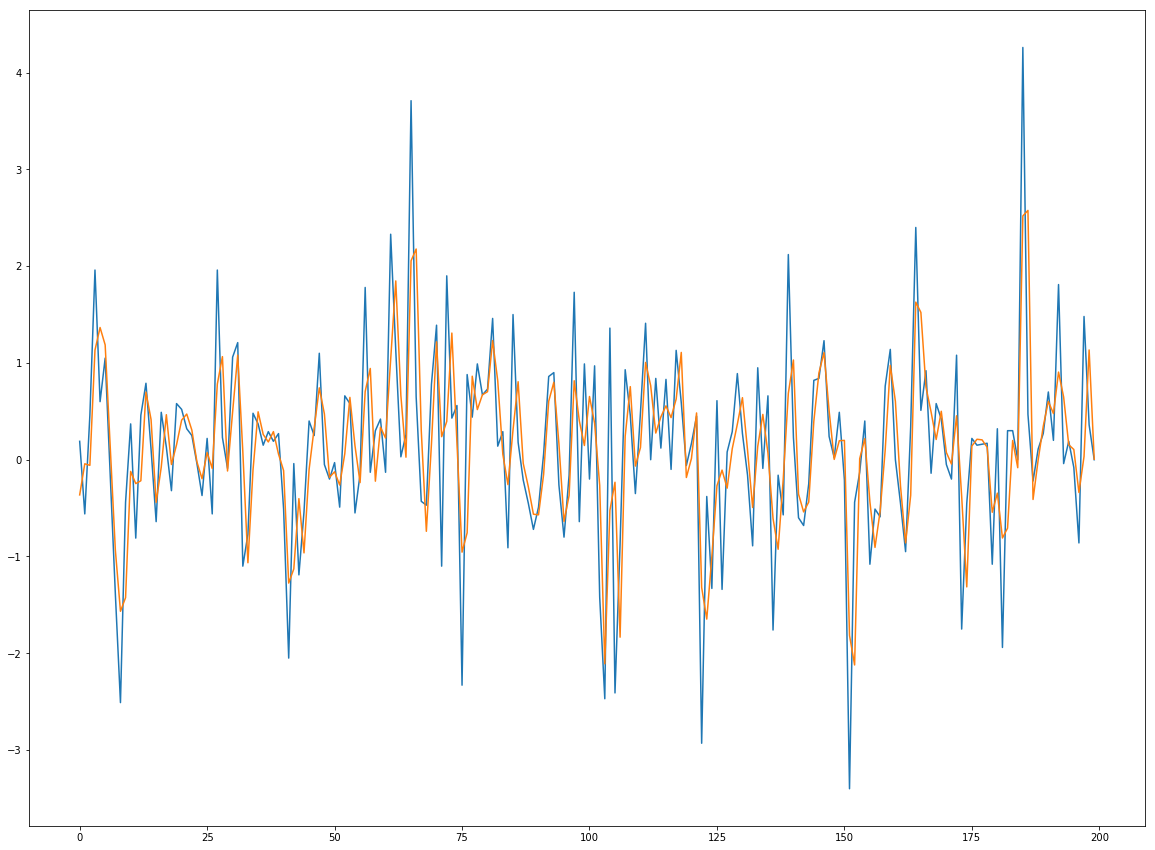

In [173]:
plt.subplots(figsize=(20,15))
plt.plot(y_test[:, 0])
plt.plot(y_test_prediction[:, 0])

In [145]:
raw_outputs

array([[ 0.43,  0.65, -1.03,  1.87,  1.06,  0.91],
       [-0.54, -0.29,  0.9 ,  1.16,  0.25, -0.26],
       [-0.68, -0.74,  0.24, -1.44, -0.5 , -1.27],
       ..., 
       [ 1.48,  0.14,  2.86,  1.25,  1.57,  1.11],
       [ 0.36, -0.4 ,  1.88,  0.47,  0.65, -0.89],
       [ 0.  , -0.35,  0.47,  0.6 , -2.07,  0.59]])